In [24]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sys
from lmfit import Minimizer, Parameters, fit_report, report_fit

## CONSTANTS ##

global R
global Tref
R = 8.62e-5 #Boltzmann constant
Tref = 273.15 #Reference temperature - 0C


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 22
    # variables        = 4
    chi-square         = 0.05657302
    reduced chi-square = 0.00314295
    Akaike info crit   = -123.191841
    Bayesian info crit = -118.827672
[[Variables]]
    B0:   -13.0976047 +/- 0.21613795 (1.65%) (init = 0.022)
    E:     0.97208560 +/- 0.04530612 (4.66%) (init = 0.65)
    E_D:   3.33639931 +/- 0.34455977 (10.33%) (init = 4.4)
    T_pk:  319.261591 +/- 0.22327179 (0.07%) (init = 309)
[[Correlations]] (unreported correlations are < 0.100)
    C(B0, E)     = -0.997
    C(E, T_pk)   = -0.770
    C(B0, T_pk)  =  0.741
    C(E, E_D)    = -0.722
    C(B0, E_D)   =  0.689
    C(E_D, T_pk) =  0.548
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 32
    # variables        = 4
    chi-square         = 0.25946394
    reduced chi-square = 0.00926657
    Akaike info crit   = -146.075950
    Bayesian i

SystemExit: 0

C:\Users\aleja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


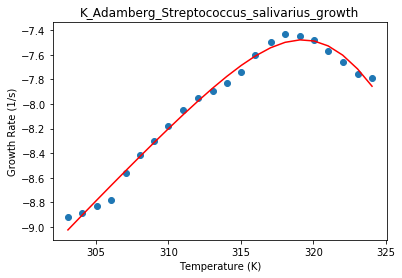

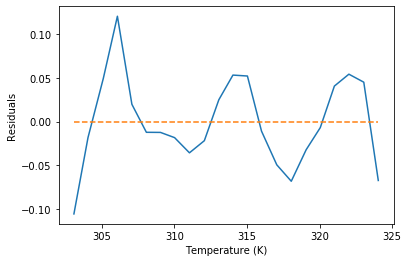

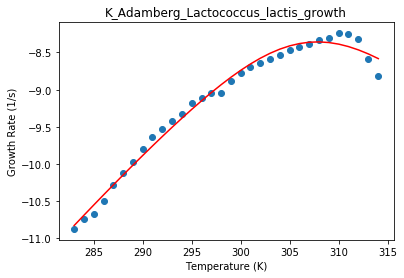

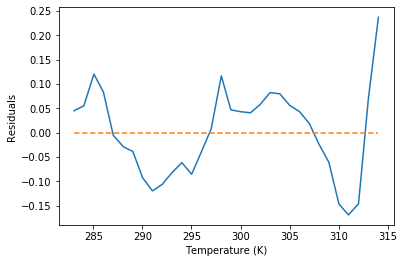

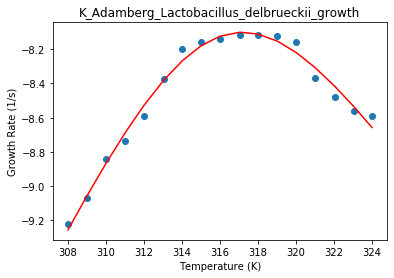

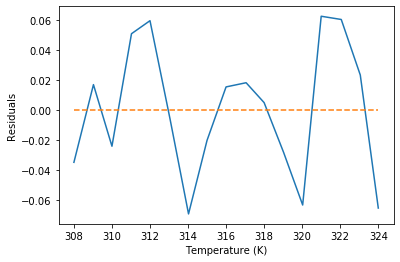

In [80]:
## FUNCTIONS ##

class schoolfield():
    
    def set_parameters(self, params):
        
        #                Name, Start, Vary, Lower, Upper
        params.add_many(('B0',   0.022, True, -np.inf, np.inf ),
                        ('E',    0.65 , True, 10E-3,   np.inf ), 
                        ('E_D',  4.4,   True, 10E-10,  np.inf ),
                        ('T_pk', 309,   True, 273.15,  np.inf))
        #Eventually the initial values will come from a function that will 
        #belong to the schoolfield class
        return params


    def model(self, params, T, mu_max):
        "Model implementation"

        #Unpack values of parameters.
        parameter_vals = params.valuesdict()
        #Basic metabolic rate
        B0 = parameter_vals['B0'] 
        #Activation energy of enzymes
        E = parameter_vals['E'] 
        #Inactivation energy of enzymes
        E_D = parameter_vals['E_D']         
        #Temperature at which peak response is observed
        T_pk = parameter_vals['T_pk']
        #Calculate theoretical predictions
        result = (B0 + \
                np.log(np.exp((-E / R) * ((1 / T) - (1 / Tref))) /\
                (1 + (E/(E_D - E)) * np.exp(E_D / R * (1 / T_pk - (1 / T))))) )
        
        return np.log(np.exp(result)) - mu_max

def main(argv):
    '''Main function'''

    #Read data
    db = pd.read_csv('Data/eme_db1.csv')
    
    data1 = db[db['ID'] == db.iloc[1, 1]]
    data2 = db[db['ID'] == db.iloc[22, 1]]
    data3 = db[db['ID'] == db.iloc[54, 1]]
    data_list = [data1, data2, data3]
    

    #Plot results
    for i in range(3):
        data = data_list[i]
        T = data.Temp + 273
        mu_max = np.log(data.TraitVal)
    
    
         #Create model object from schoolfield class
        model = schoolfield()
        #Set parameters of the model
        params = Parameters()
        params = model.set_parameters(params)

        #Fit model
        minner = Minimizer(userfcn = model.model, params = params, 
                           fcn_args = (T, mu_max))
        result = minner.minimize(method = 'leastsq')
        

        
        plt.figure(i)
        plt.scatter(T, mu_max)
        max_y = mu_max.max() * 0.9
        min_y = mu_max.min() * 1.1
        
        #print("max data " + str(i) + " --> " + str(max_y))
        #print(" ")
        #print("min data  " + str(i) +" --> " + str(min_y))

        #plt.ylim(min_y, max_y)
        plt.plot(T, model.model(result.params, T, mu_max) + mu_max, color = 'red')
        plt.xlabel('Temperature (K)')
        plt.ylabel('Growth Rate (1/s)')
        plt.title(str(data.iloc[1,1]))
        plt.savefig('Results/' + str(i) + '_tpc.pdf')
    
        plt.figure(i + 3)
        plt.plot(T, result.residual)
        zero = T * 0
        plt.plot(T, zero, '--')
        plt.ylabel('Residuals')
        plt.xlabel('Temperature (K)')
        plt.savefig('Results/' + str(i) + '_residuals.pdf')

        
        print(fit_report(result))


    return 0

## CODE ##

if (__name__ == '__main__'):
    status = main(sys.argv)
    sys.exit(status)